<a href="https://colab.research.google.com/github/cmong42/AlumniMapAndPythonProjects/blob/main/Copy_of_ChristineOngLab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset:** This lab will use a dataset that represents water flow out of a dame versus change of water level. The dataset is uploaded in iLearn. You need to upload it to your Google Colab. 

**Step-1: Import Libraries:** The first step in any project is to import the libraries we are going to use

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.io import loadmat
#set default figure size
mpl.rcParams['figure.figsize'] = (12, 8)

**Step-2: Load the Data:** The next step is to load the data. While loading the data, let's also insert a column of ones to be the first column in the feature set. This column represents $X_0=1$, which will be multiplied by $\theta_0$.

In [ ]:
data = pd.read_csv('Lab2_dataset.csv')
data_train = data.loc[0:11,['X', 'y']]
data_test = data.loc[0:20,['Xtest', 'ytest']]
data_val = data.loc[0:20,['Xval', 'yval']]

# Include a column of 1s in X to represent X_0 that will be multiplied by theta_0
X_train = np.c_[np.ones_like(data_train['X']), data_train['X']]
y_train = np.c_[data_train['y']]

X_val = np.c_[np.ones_like(data_val['Xval']), data_val['Xval']]
y_val = np.c_[data_val['yval']]

X_test = np.c_[np.ones_like(data_test['Xtest']), data_test['Xtest']]
y_test = np.c_[data_test['ytest']]

*Explore the data:* Let's look at the data: 

In [ ]:
print('X_train:') 
print(X_train)
print('y_train:')
print(y_train)

X_train:
[[  1.     -15.9368]
 [  1.     -29.153 ]
 [  1.      36.1895]
 [  1.      37.4922]
 [  1.     -48.0588]
 [  1.      -8.9415]
 [  1.      15.3078]
 [  1.     -34.7063]
 [  1.       1.3892]
 [  1.     -44.3838]
 [  1.       7.0135]
 [  1.      22.7627]]
y_train:
[[ 2.1343]
 [ 1.1733]
 [34.3591]
 [36.838 ]
 [ 2.809 ]
 [ 2.1211]
 [14.7103]
 [ 2.6142]
 [ 3.7402]
 [ 3.7317]
 [ 7.6277]
 [22.7524]]


*Plot the data:* It is often useful to create a scatter plot of your data. Sometimes this helps identify the best polynomial order that fits your data. For that, we will create a function that we can use to plot our data. Here, we will create a general plot function that we can use to plot the data and later when we find the optimal model, we can also use the function to plot the optimal model on the same Figure with that data. The if condition in this function is intended to help us later when we try to plot the developed linear regression model on the scatter plot of the training data. Note here: once we know our model  $\theta_0 + \theta_1 X_1$, we will substitute by a rane of $X$  to find our line and plot it on the data. 

In [ ]:
def plotData(X, y, theta = np.array(([0],[0])), reg = 0):
    plt.figure(figsize=(12, 8))
    plt.scatter(X[:, 1], y, s = 50, c = 'red', marker = 'x', linewidths = 1, label = 'Data')
    plt.grid(True)
    plt.title('Water Flow Data')
    plt.xlabel('Change in water level (x)')
    plt.ylabel('Water flowing out of the dam (y)')
    if theta.any() != 0:
        plt.plot(np.linspace(X.min(), X.max()), theta[0] + theta[1] * np.linspace(X.min(), X.max()), 
                                                 label = 'Optimized linear fit')
        plt.title('Water Data: Linear Fit')
    print(theta)
    plt.legend()

Now, let's use the plot function: 

[[0]
 [0]]


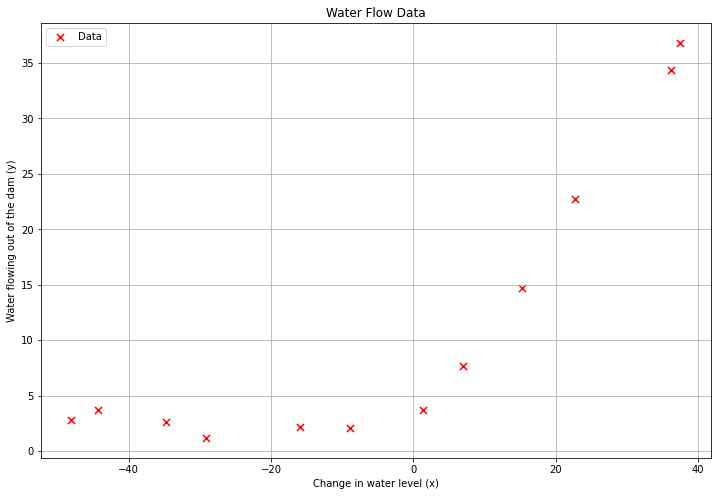

In [ ]:
plotData(X_train, y_train)

**Step-3: Implement a Linear Regression Model:** 

*Step-3.1: Cost Function and Gradient:* Let's implement a function to calculate the cost $J$. This will be useful later in most of our next steps. This function will return the cost value. This is a general implementation that works even for regularized functions.

In [ ]:
def cost(theta, X, y, reg = 0):
    m = y.size
    f = np.dot(X,theta).reshape((m, 1))
    J1 = (1 / (2 * m)) * np.sum(np.square(f - y))
    J2 = (reg / (2 * m)) * theta[1:].T.dot(theta[1:])
    J = J1 + J2
    grad = ((1 / m)*(X.T.dot(f - y)) + (reg / m) * np.r_[[[0]], theta[1:].reshape(-1, 1)]).ravel() 
    return J, grad

#Answer to Question 1.1 and 1.2

*Step-3.2: Gradient Descent Algorithm:* Next, we implement the iterations of the gradient descent.  

In [ ]:
def gradient_descent(alpha, x, y):
    iterations = []
    mse_list = []
    m = y.size 
    theta = np.ones(2)
    previous_J = cost(theta, x, y, reg = 0)[0]+1
    curr_iter = 1
    while True:
        J, grad = cost(theta, x, y, reg = 0) 
        if J>=previous_J:
          plt.figure(figsize=(12, 8))
          plt.scatter(iterations, mse_list, s = 50, c = 'blue', marker = '.', linewidths = 1, label = 'Data')
          plt.grid(True)
          plt.title('')
          plt.ylabel('Mean Squared Error (y)')
          plt.xlabel('Number of Iterations (x)')
          plt.title('Answer to Question 1.2: MSE vs Iterations')
          return theta
        else:
          theta = theta - alpha * grad  # update
          previous_J = J
          curr_iter+=1
          iterations.append(curr_iter)
          mse_list.append(J)



# Answer to Question 1.3

## Graph where Alpha = 0.1

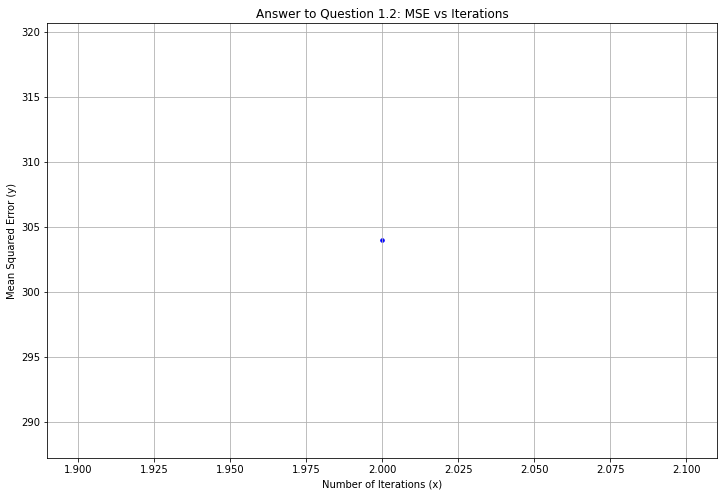

In [ ]:
alpha = 0.1 # learning rate
theta = gradient_descent(alpha, X_train, y_train)

With an alpha or step size of 0.1, it appears that J never converged, hence, the squared error's only showed one point. This alpha is not a good alpha because the program overshot the optimal MSE, as shown in the graph and never converged.

## Graph where Alpha = 0.001

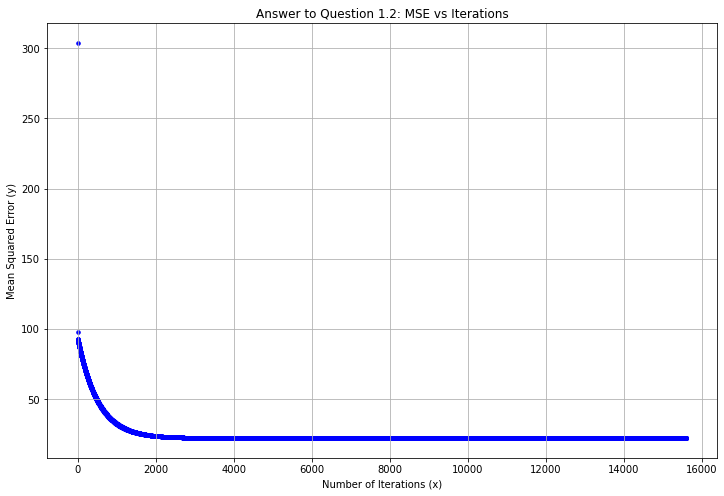

In [ ]:
alpha = 0.001 # learning rate
theta = gradient_descent(alpha, X_train, y_train)

With an alpha of 0.001, J converged eventually with a reasonable amount of iterations between 14,000 and 16,000. Hence, this is a good alpha, or step-size. So far, this alpha represents the best step size.

## Graph where Alpha = 0.0001

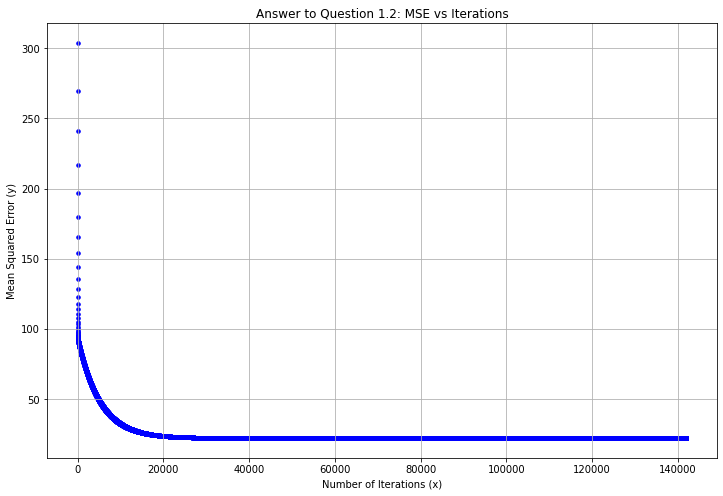

In [ ]:
alpha = 0.0001 # learning rate
theta = gradient_descent(alpha, X_train, y_train)

With an alpha of 0.0001, J took nearly ten times as long to converge compared with an alpha of 0.001. Although the optimal theta was eventually found, with this alpha, we used more time and computing power than necessary. Hence, this is not a good alpha, or step size.

[13.08792408  0.36777904]


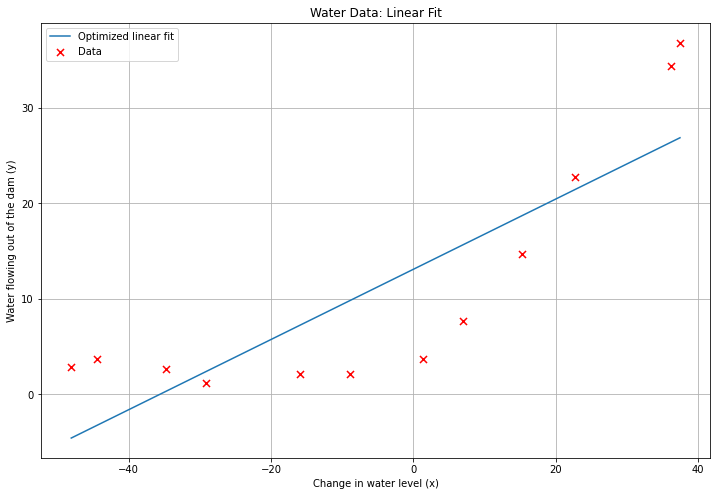

In [ ]:
plotData(X_train, y_train, theta)

# Answer to Question 2.1 and 2.2

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


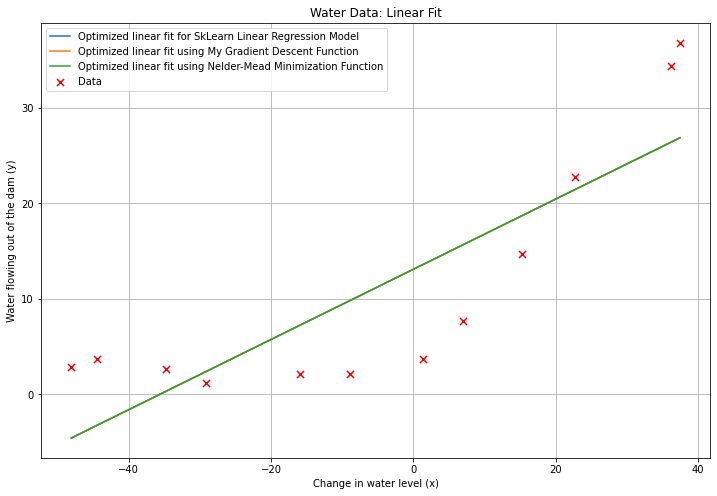

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from scipy.optimize import minimize

def optimalTheta(theta, X, y, reg = 0):
    #Nelder-Mead yields best fit
    res = minimize(fun = cost, x0 = theta, args = (X, y, reg), method = 'Nelder-Mead', jac = True)
    return res.x

initial_theta = np.ones((X_train.shape[1], 1))
opt_theta = optimalTheta(initial_theta, X_train, y_train)

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
predicted_y = linear_model.predict(X_test)
plt.figure(figsize=(12, 8))
plt.scatter(X_train[:, 1], y_train, s = 50, c = 'red', marker = 'x', linewidths = 1, label = 'Data')
plt.grid(True)
plt.title('Water Flow Data')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')

plt.plot(np.linspace(X_train.min(), X_train.max()), linear_model.intercept_[0] + linear_model.coef_[0][1] * np.linspace(X_train.min(), X_train.max()), 
                                              label = 'Optimized linear fit for SkLearn Linear Regression Model')
plt.plot(np.linspace(X_train.min(), X_train.max()), theta[0]+theta[1] * np.linspace(X_train.min(), X_train.max()), 
                                              label = 'Optimized linear fit using My Gradient Descent Function')
plt.plot(np.linspace(X_train.min(), X_train.max()), opt_theta[0]+opt_theta[1] * np.linspace(X_train.min(), X_train.max()), 
                                              label = 'Optimized linear fit using Nelder-Mead Minimization Function')

plt.title('Water Data: Linear Fit')
    
plt.legend()

All three methods led to the same result, that is, all three lines overlapped, indicating that their thetas are exactly the same.

# Answer for Question 2.3: MSE for Linear Regression Model

In [ ]:
print("MSE for Sklearn's Linear Regression Model: ", mean_squared_error(y_test, predicted_y))

MSE for Sklearn's Linear Regression Model:  65.01148977037028


# Answer for Question 3.1 and 3.2

In [380]:
def normalize(X):
  norm_X = (X-np.min(X))/(np.max(X-np.min(X)))
  return norm_X

def standardize(X):
  stand_X = (X*np.average(X))/(np.std(X))
  return stand_X

def higher_order_features(X, degree):
  X = normalize(X)
  return np.power(X, degree)



In [586]:
from sklearn.base import TransformerMixin
import math
from scipy.optimize import minimize

def cost_polynomial(theta, X, y, reg = 0):
    m = y.size
    f = np.dot(X,theta)
    J1 = (1 / (2 * m)) * np.sum(np.square(f - y))
    J2 = (reg / (2 * m)) * theta[1:].T.dot(theta[1:])
    J = J1 + J2
    grad = ((1 / m)*(X.T.dot(f - y)) + (reg / m) * np.r_[[[0]], theta[1:].reshape(-1, 1)]).ravel() 
    return J, grad

def optimalTheta(theta, X, y, reg = 0):
    res = minimize(fun = cost_polynomial, x0 = theta, args = (X, y, reg), method = 'Nelder-Mead', jac = True)
    return res.x

In [603]:
def plotDataPolynomial(X, y, opt_theta, degree):
    plt.figure(figsize=(12, 8))
    plt.grid(True)
    plt.title('Water Flow Data')
    plt.xlabel('Change in water level (x)')
    plt.ylabel('Water flowing out of the dam (y)')
    plt.plot(opt_theta, label = 'Optimized polynomial fit using Nelder-Mead Minimization Function')
    try:
      plt.scatter(X[:, 1], y, s = 50, c = 'red', marker = 'x', linewidths = 1, label = 'Data')
    except:
      plt.scatter(X, y, s = 50, c = 'red', marker = 'x', linewidths = 1, label = 'Data')
    plt.title('Water Data: Polynomial Fit')
    plt.legend()

In [604]:
mses = []

def plotLearningCurve(theta, X, y, Xval, yval, reg = 0):
    m = y.size

    error_train = np.zeros((m, 1))
    error_val = np.zeros((m, 1))
    
    example_num = np.arange(1, (X.shape[0] + 1))
    for i in np.arange(m):
        
        opt_theta = optimalTheta(theta, X[:i + 1], y[:i + 1], reg)
        error_train[i] = cost_polynomial(opt_theta, X[:i + 1], y[:i + 1], reg)[0]
        error_val[i] = cost_polynomial(opt_theta, Xval, yval, reg)[0]

    plt.figure(figsize = (12, 8))
    plt.plot(example_num, error_train, label = 'Training Error')
    plt.plot(example_num, error_val, label = 'Validation Error')
    plt.title('Learning Curve: No Regularization')
    if reg != 0:
        plt.title('Learning Curve: Lambda = {0}'.format(reg))
    plt.xlabel('Number of training examples')
    plt.ylabel('Mean Square Error')
    plt.legend()
    plt.grid(True)
    print("MSE's: ", (error_train+error_val)**2)
    

## Setting Degree to 8

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


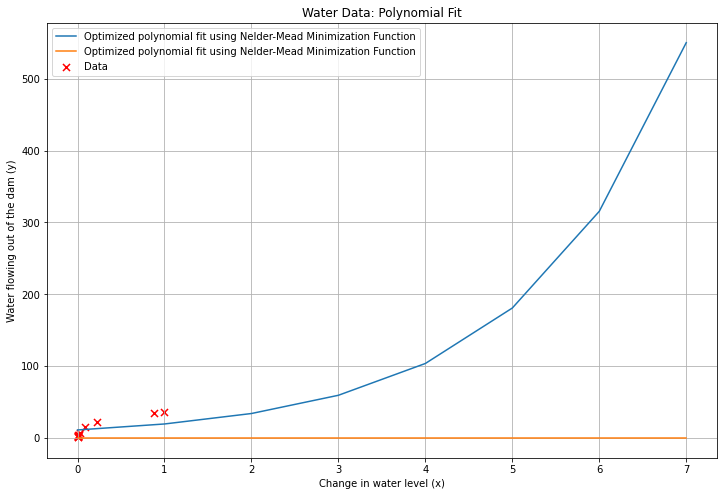

In [607]:
initial_theta_polynomial = np.ones((X_train.shape[1], 1))
optimal_thetas = []
for i in range(8):
  optimal_thetas.append(optimalTheta(initial_theta_polynomial, higher_order_features(X_train, i), y_train))
plotDataPolynomial(higher_order_features(X_train, 8), y_train, optimal_thetas, 8)

## Setting Degree to 2

[[1.]
 [1.]]


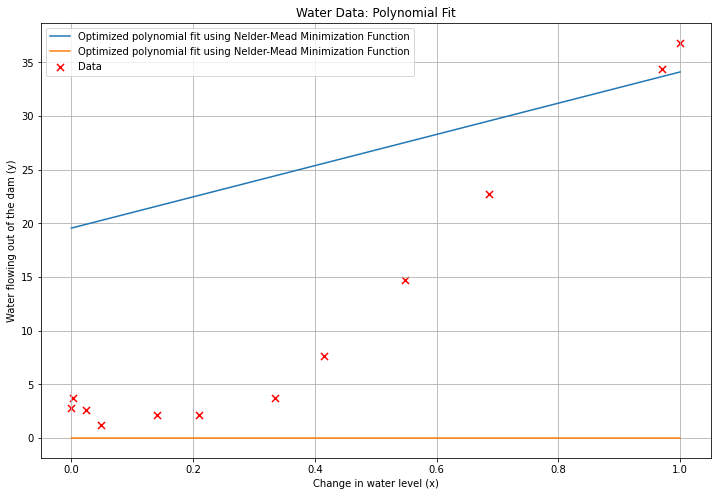

In [595]:

initial_theta_polynomial = np.ones((X_train.shape[1], 1))
print(initial_theta_polynomial)
optimal_thetas = []
for i in range(1, 3):
  optimal_thetas.append(optimalTheta(initial_theta_polynomial, higher_order_features(X_train, i), y_train, reg = 0))
plotDataPolynomial(higher_order_features(X_train, 2), y_train, optimal_thetas, 2)

# Answer for Question 3.3

## Graph for Degree 8 with Reg = 0

MSE's:  [[ 9941517.94255251]
 [10348813.26071537]
 [ 6070080.19714888]
 [ 5623324.56295704]
 [ 6799716.20632912]
 [ 7912537.45036231]
 [ 7841156.3031759 ]
 [ 8667587.02559474]
 [ 9270600.01381956]
 [ 9791335.29754143]
 [ 9946070.36397303]
 [ 9870951.73320018]]


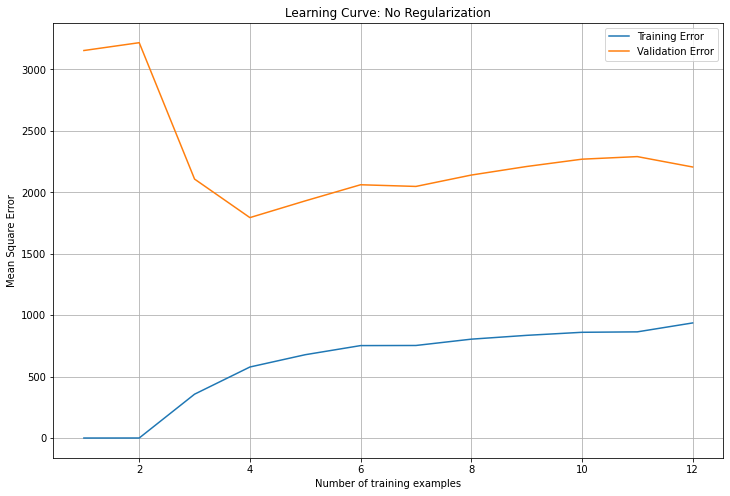

In [591]:
optimal_thetas = []
for i in range(8):
  optimal_thetas.append(optimalTheta(initial_theta_polynomial, higher_order_features(X_train, i), y_train, reg = 0))
plotLearningCurve(optimal_theta, higher_order_features(X_train, 8), y_train, higher_order_features(X_val, 8), y_val, reg = 0)

## Graph for Degree 8 with Reg = 1

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


MSE's:  [[ 9941517.94255259]
 [10348813.2607154 ]
 [ 6070080.15429875]
 [ 5623324.56295859]
 [ 6799716.20633008]
 [ 7912537.45036297]
 [ 7841156.3031765 ]
 [ 8667587.0255952 ]
 [ 9270600.01381994]
 [ 9791335.29754174]
 [ 9946070.36397331]
 [ 9870951.7332005 ]]


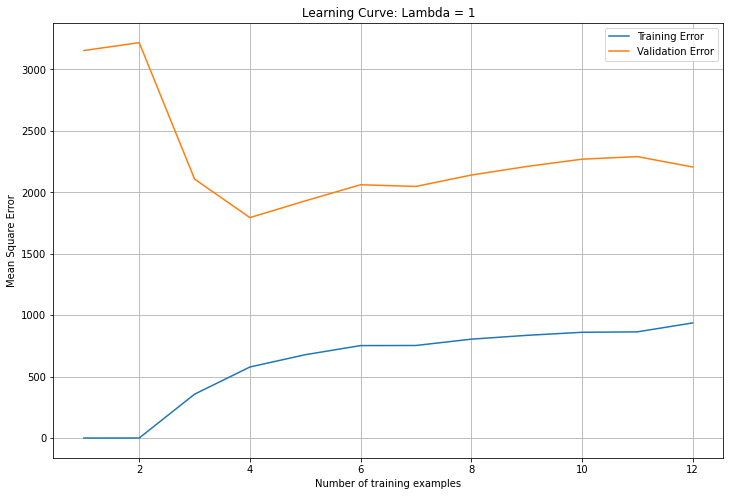

In [592]:
optimal_thetas = []
for i in range(8):
  optimal_thetas.append(optimalTheta(initial_theta_polynomial, higher_order_features(X_train, i), y_train, reg = 1))
plotLearningCurve(optimal_theta, higher_order_features(X_train, 8), y_train, higher_order_features(X_val, 8), y_val, reg = 1)

## Graph for Degree 8 with Reg = 100

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


MSE's:  [[ 9941518.24742591]
 [10348813.36690436]
 [ 6070079.1374559 ]
 [ 5623324.56311123]
 [ 6799714.60578965]
 [ 7912537.45042812]
 [ 7841156.3032358 ]
 [ 8667587.08895264]
 [ 9270600.00758208]
 [ 9791335.29757236]
 [ 9946070.73725617]
 [ 9870951.73323222]]


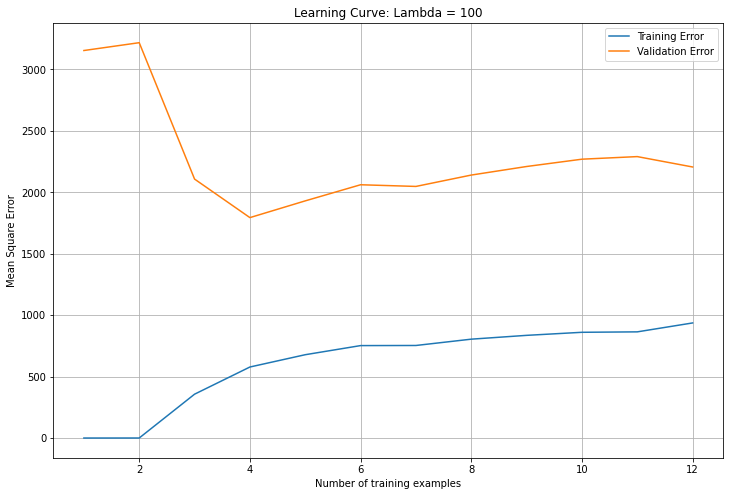

In [593]:
optimal_thetas = []
for i in range(8):
  optimal_thetas.append(optimalTheta(initial_theta_polynomial, higher_order_features(X_train, i), y_train, reg = 100))
plotLearningCurve(optimal_theta, higher_order_features(X_train, 8), y_train, higher_order_features(X_val, 8), y_val, reg = 100)

## Plot for test data using no regularization

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


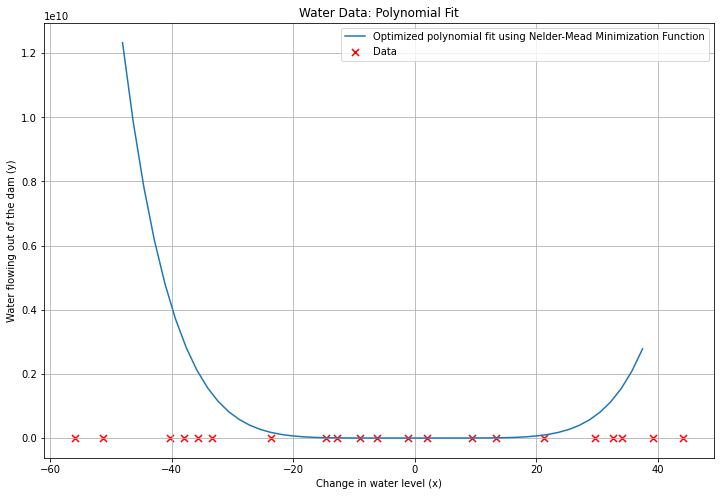

In [ ]:
optimal_theta_test = higher_order_features(normalize(optimalTheta(initial_theta_polynomial, X_train, y_train, reg = 0)), 8)
plotDataPolynomial(X_test, y_test, optimal_theta_test, 8)

## MSE and Learning curve for test data plotted with no regularization

MSE's:  [[ 17815.78048456]
 [321532.41545338]
 [  1355.53342177]
 [  4950.07614981]
 [  1870.98627001]
 [  1816.11358812]
 [  2324.86972379]
 [  1424.08152317]
 [  1356.1130182 ]
 [  4673.46931103]
 [  4793.82079028]
 [  4388.76924871]
 [  4086.16609823]
 [  4208.78630539]
 [  4172.87515626]
 [  3882.48773955]
 [  3714.99815961]
 [  3613.40710423]
 [  3767.11101628]
 [  3601.25529886]
 [  3554.86092587]]


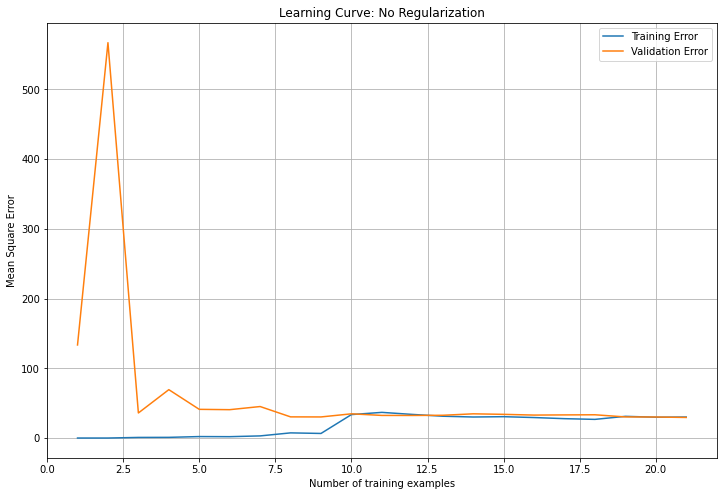

In [ ]:
optimal_theta5 = normalize(optimalTheta(initial_theta_polynomial, X_train, y_train, reg = 0))
plotLearningCurve(optimal_theta5, X_test, y_test, X_val, y_val, 0)